In [1]:
#DeterministicScoreCard


In [2]:
import os
import weatherbench2
import xarray as xr
import math
from weatherbench2.regions import SliceRegion, ExtraTropicalRegion
from weatherbench2.evaluation import evaluate_in_memory
from weatherbench2 import config
import numpy as np
import sigkernel
import torch
from einops import rearrange
from itertools import product
import cython
import matplotlib.pyplot  as plt
import tqdm
#import Functions as fu
import line_profiler
from datetime import datetime, timedelta
from multiprocessing import Pool, cpu_count
import time
from weatherbench2.metrics import MSE, ACC
from weatherbench2.regions import SliceRegion
import seaborn as sns
from dateutil.relativedelta import relativedelta
import ScorecardFunctions as SCF





In [3]:
import apache_beam

In [4]:
startdate = {0:'2020-01-01',1:'2020-02-01',2:'2020-03-01',3:'2020-04-01',4:'2020-05-01',5:'2020-06-01',6:'2020-07-01',7:'2020-08-01',8:'2020-09-01',9:'2020-10-01',10:'2020-11-01',11:'2020-12-01'}
enddate = {0:'2020-01-03',1:'2020-02-03',2:'2020-03-03',3:'2020-04-03',4:'2020-05-03',5:'2020-06-03',6:'2020-07-03',7:'2020-08-03',8:'2020-09-03',9:'2020-10-03',10:'2020-11-03',11:'2020-12-03'}

In [5]:
overallIFSENSE = xr.open_dataset('./IFSCard/ENSERAmonths11.nc')
for i in range(11):
    results = xr.open_dataset('./IFSCard/ENSERAmonths' + str(i) + '.nc')
    overallIFSENSE = overallIFSENSE + results

overallIFSENSE = overallIFSENSE/12
overallIFSENSE = overallIFSENSE.isel(lead_time=slice(1, None))

overallFUXI = xr.open_dataset('./FUXICard/FUXImonths11.nc')
for i in range(11):
    results = xr.open_dataset('./FUXICard/FUXImonths' + str(i) + '.nc')
    overallFUXI = overallFUXI + results

overallFUXI = overallFUXI/12

In [6]:
percentage_diff = (overallFUXI - overallIFSENSE) / overallIFSENSE * 100
percentage_diff

<xarray.Dataset>
Dimensions:         (lead_time: 60, region: 3, metric: 2, level: 2)
Coordinates:
  * lead_time       (lead_time) timedelta64[ns] 0 days 06:00:00 ... 15 days 0...
  * region          (region) object 'northernhemisphere' ... 'southernhemisph...
  * metric          (metric) object 'acc' 'mse'
  * level           (level) int32 500 850
Data variables:
    geopotential    (metric, region, lead_time, level) float64 0.02242 ... -0...
    temperature     (metric, region, lead_time, level) float64 0.1149 ... 5.72
    2m_temperature  (metric, region, lead_time) float64 2.43 3.693 ... 4.582
    10m_wind_speed  (metric, region, lead_time) float64 0.5467 0.4789 ... 189.9

In [7]:
for var in percentage_diff.data_vars:
    if 'metric' in percentage_diff[var].dims:
        percentage_diff[var].loc[dict(metric='acc')] *= -1

In [8]:
geopotential = percentage_diff['geopotential'].values
geopotential.shape #now have normal array(metric =2, region =3, leadtime = 60, level =2)

temperature = percentage_diff['temperature'].values
m2_temperature = percentage_diff['2m_temperature'].values
m10_wind_speed = percentage_diff['10m_wind_speed'].values

In [9]:
weights = np.array([0.07704437, 0.23039114, 0.38151911, 0.52897285, 0.67133229,
       0.80722643, 0.93534654, 1.05445875, 1.16341595, 1.26116882,
       1.34677594, 1.41941287, 1.47838008, 1.52310968, 1.55317091,
       1.56827425, 1.56827425, 1.55317091, 1.52310968, 1.47838008,
       1.41941287, 1.34677594, 1.26116882, 1.16341595, 1.05445875,
       0.93534654, 0.80722643, 0.67133229, 0.52897285, 0.38151911,
       0.23039114, 0.07704437])

southernweights = weights[0:12]
tropicweights = weights[12:20]
northernweights = weights[20:32]

#print(weights[0:12])

In [10]:
def latsplit(input):
    inputsouthern = np.sum(input[0:12,:,:,:] * southernweights[:, None, None, None], axis=0)
    inputst = np.mean(inputsouthern, axis=0)
    inputsoutherndistance = inputst[:, 1] + inputst[:, 2] - 2 * inputst[:, 0]

    inputtropic = np.sum(input[12:20,:,:,:] * tropicweights[:, None, None, None], axis=0)
    inputtt = np.mean(inputtropic, axis=0)
    inputtropicdistance = inputtt[:, 1] + inputtt[:, 2] - 2 * inputtt[:, 0]

    inputnorthern = np.sum(input[20:32,:,:,:] * northernweights[:, None, None, None], axis=0)
    inputnt = np.mean(inputnorthern, axis=0)
    inputnortherndistance = inputnt[:, 1] + inputnt[:, 2] - 2 * inputnt[:, 0]

    return (inputsoutherndistance,inputtropicdistance,inputnortherndistance)



In [ ]:
# pkarraylat = np.sum(pkarray * usedweights[:, None, None, None], axis=0)
#     # pktime = np.mean(pkarraylat, axis=0)
#     # distance = pktime[:, 1] + pktime[:, 2] - 2 * pktime[:, 0]

In [16]:
obs_path = 'gs://weatherbench2/datasets/era5/1959-2022-6h-64x32_equiangular_conservative.zarr'
observationsera = xr.open_zarr(obs_path)

<xarray.Dataset>
Dimensions:                                           (time: 92044,
                                                       longitude: 64,
                                                       latitude: 32, level: 13)
Coordinates:
  * latitude                                          (latitude) float64 -87....
  * level                                             (level) int64 50 ... 1000
  * longitude                                         (longitude) float64 0.0...
  * time                                              (time) datetime64[ns] 1...
Data variables: (12/38)
    10m_u_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_v_component_of_wind                           (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    10m_wind_speed                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    2m_temperature                                    (time, longitude, latitude) float32 dask.array<chunksize=(100, 64, 32), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    ...                                                ...
    type_of_high_vegetation                           (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    type_of_low_vegetation                            (longitude, latitude) float32 dask.array<chunksize=(64, 32), meta=np.ndarray>
    u_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    v_component_of_wind                               (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    vertical_velocity                                 (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>
    wind_speed                                        (time, level, longitude, latitude) float32 dask.array<chunksize=(100, 13, 64, 32), meta=np.ndarray>

In [ ]:
#IFS ENS mean
forecast2 = xr.open_zarr('gs://weatherbench2/datasets/ifs_ens/2018-2022-64x32_equiangular_conservative_mean.zarr')
forecast2
forecast2 = forecast2.sel(prediction_timedelta=forecast2.prediction_timedelta != np.timedelta64(0, 'D'))
#12 Hour increments, pred 6 Hours #61

In [ ]:
#Fuxi
forecast11 = xr.open_zarr('gs://weatherbench2/datasets/fuxi/2020-64x32_equiangular_conservative.zarr')
forecast11
#12 Hour increments, pred 6 Hours #60, no time 0

## Calculation
Only run next two cells if you want to recalculate results

In [ ]:
geo500 = np.zeros((32,6,60,3))
for monthval in range(12):
    geo500 +=SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'geopotential', levelval = 500, region = "Doesn't matter")
np.save('Newresults/geo500.npy', geo500)


geo850 = np.zeros((32,6,60,3))
for monthval in range(12):
    geo850 = geo850 + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'geopotential', levelval = 850, region = "Doesn't matter")
np.save('Newresults/geo850.npy', geo850)

temp500 = np.zeros((32,6,60,3))
for monthval in range(12):
    temp500 = temp500 + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'temperature', levelval = 500, region = "Doesn't matter")
np.save('Newresults/temp500.npy', temp500)

temp850 = np.zeros((32,6,60,3))
for monthval in range(12):
    temp850 = temp850 + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'temperature', levelval = 850, region = "Doesn't matter")
np.save('Newresults/temp850.npy', temp850)

temp2m = np.zeros((32,6,60,3))
for monthval in range(12):
    temp2m = temp2m + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = '2m_temperature', levelval = 0, region = "Doesn't matter")
np.save('Newresults/temp2m.npy', temp2m)

wind10m = np.zeros((32,6,60,3))
for monthval in range(12):
    wind10m = wind10m + SCF.workflowfullparallelmonthly(observationsera, forecast2, days = 3, lag = 60, zero = 1, month = monthval, variableval = '10m_wind_speed', levelval = 0, region = "Doesn't matter")
np.save('Newresults/wind10m.npy', wind10m)

12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6)

In [24]:
geo500fuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    geo500fuxi +=SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'geopotential', levelval = 500, region = "Doesn't matter")
np.save('Newresults/geo500fuxi.npy', geo500fuxi)

geo850fuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    geo850fuxi = geo850fuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'geopotential', levelval = 850, region = "Doesn't matter")
np.save('Newresults/geo850fuxi.npy', geo850fuxi)

temp500fuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    temp500fuxi = temp500fuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'temperature', levelval = 500, region = "Doesn't matter")
np.save('Newresults/temp500fuxi.npy', temp500fuxi)

temp850fuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    temp850fuxi = temp850fuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = 'temperature', levelval = 850, region = "Doesn't matter")
np.save('Newresults/temp850fuxi.npy', temp850fuxi)

temp2mfuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    temp2mfuxi = temp2mfuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = '2m_temperature', levelval = 0, region = "Doesn't matter")
np.save('Newresults/temp2mfuxi.npy', temp2mfuxi)

wind10mfuxi = np.zeros((32,6,60,3))
for monthval in range(12):
    wind10mfuxi = wind10mfuxi + SCF.workflowfullparallelmonthly(observationsera, forecast11, days = 3, lag = 60, zero = 1, month = monthval, variableval = '10m_wind_speed', levelval = 0, region = "Doesn't matter")
np.save('Newresults/wind10mfuxi.npy', wind10mfuxi)

12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6), range(6, 9), range(9, 12), range(12, 15), range(15, 18), range(18, 21), range(21, 24), range(24, 27), range(27, 30), range(30, 32)]
12
[range(0, 3), range(3, 6)

In [11]:
geo500 = np.load("Newresults/geo500.npy")
geo850= np.load("Newresults/geo850.npy")
temp500 = np.load("Newresults/temp500.npy")
temp850 = np.load("Newresults/temp850.npy")
temp2m = np.load("Newresults/temp2m.npy")
wind10m = np.load("Newresults/wind10m.npy")

geo500fuxi = np.load("Newresults/geo500fuxi.npy")
geo850fuxi = np.load("Newresults/geo850fuxi.npy")
temp500fuxi = np.load("Newresults/temp500fuxi.npy")
temp850fuxi = np.load("Newresults/temp850fuxi.npy")
temp2mfuxi = np.load("Newresults/temp2mfuxi.npy")
wind10mfuxi = np.load("Newresults/wind10mfuxi.npy")



In [12]:
ens = [geo500,geo850,temp500,temp850,temp2m,wind10m]
fuxi = [geo500fuxi,geo850fuxi,temp500fuxi,temp850fuxi,temp2mfuxi,wind10mfuxi]

storageval = np.zeros((6,60,3))
storagevalfuxi = np.zeros((6,60,3))

for i in range(6):
    south, tropics, northern = latsplit(ens[i])
    storageval[i,:,0] = northern
    storageval[i,:,1] = tropics
    storageval[i,:,2] = south
    south1, tropics1, northern1 = latsplit(fuxi[i])
    storagevalfuxi[i,:,0] = northern1
    storagevalfuxi[i,:,1] = tropics1
    storagevalfuxi[i,:,2] = south1

    



In [13]:
percentage_diffsigkernel = (storagevalfuxi - storageval) / storageval * 100
percentage_diffsigkernel[:,0,:] = 0

C:\Users\arche\AppData\Local\Temp\ipykernel_22472\1836386619.py:1: RuntimeWarning: invalid value encountered in divide
  percentage_diffsigkernel = (storagevalfuxi - storageval) / storageval * 100


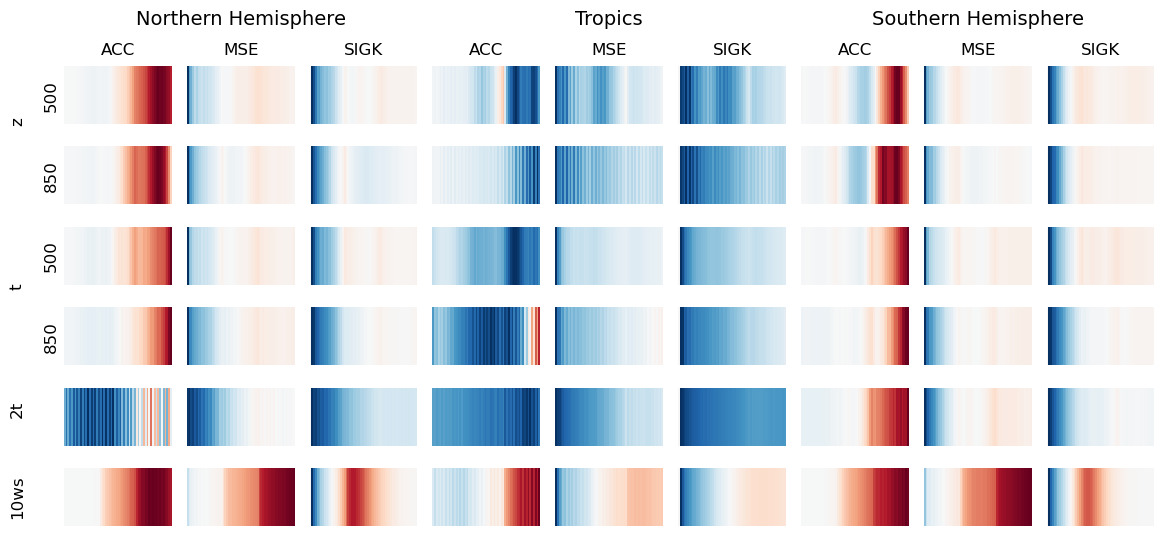

In [15]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import seaborn as sns

regions = ['Northern Hemisphere', 'Tropics', 'Southern Hemisphere']
metrics = ['ACC', 'MSE','SIGK']
levels = [500, 850]

# Set up the figure and gridspec layout
fig = plt.figure(figsize=(12, 6)) 
spec = gridspec.GridSpec(
    nrows=2 + len(levels) * 2 + 2,  # 2 header rows + 2 levels for geopotential + 2 levels for temperature + 2 rows for 2m_temperature and 10m_wind speed
    ncols=len(regions) * len(metrics), 
    figure=fig, 
    height_ratios=[-0.1, -0.1] + [1] * (len(levels) * 2) + [1, 1]  
)

# region titles 
for region_idx, region in enumerate(regions):
    region_start_col = region_idx * len(metrics)
    region_end_col = region_start_col + len(metrics)

    # Add region title centered above its two metric columns
    ax_region = fig.add_subplot(spec[0, region_start_col:region_end_col])
    ax_region.set_title(region, fontsize=14) 
    ax_region.axis('off') 

# metric titles
for region_idx in range(len(regions)):
    for metric_idx, metric in enumerate(metrics):
        col_idx = region_idx * len(metrics) + metric_idx

        # Add the metric title manually with lowered vertical position
        ax_metric = fig.add_subplot(spec[1, col_idx])
        ax_metric.text(0.5, 1, metric, ha='center', va='center', fontsize=12, transform=ax_metric.transAxes) #fontweight='bold'
        ax_metric.axis('off') 

# Geopotential
fig.text(0.04, 0.75, 'z', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2, col_idx])
            
            if metric_idx<2:
                geopotential_plot_data = geopotential[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    geopotential_plot_data = percentage_diffsigkernel[0,:,region_idx]
                else:
                    geopotential_plot_data = percentage_diffsigkernel[1,:,region_idx]
                    
            data_for_plot = geopotential_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )
                
    ax_label = fig.add_subplot(spec[level_idx + 2, 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off')

# Temperature
fig.text(0.04, 0.475, 't', ha='center', va='center', fontsize=12, rotation='vertical')
for level_idx, level in enumerate(levels):
    for region_idx in range(len(regions)):
        for metric_idx in range(len(metrics)):
            col_idx = region_idx * len(metrics) + metric_idx
            ax = fig.add_subplot(spec[level_idx + 2 + len(levels), col_idx])
            
            if metric_idx<2:
                temperature_plot_data = temperature[metric_idx, region_idx, :, level_idx]
            else:
                if level_idx == 0:
                    temperature_plot_data = percentage_diffsigkernel[2,:,region_idx]
                else:
                    temperature_plot_data = percentage_diffsigkernel[3,:,region_idx]


            data_for_plot = temperature_plot_data[np.newaxis, :]
            sns.heatmap(
                data_for_plot,
                cmap='RdBu_r',
                center=0,
                linewidths=0,
                cbar=False,
                xticklabels=False,
                yticklabels=False,
                ax=ax
            )


    ax_label = fig.add_subplot(spec[level_idx + 2 + len(levels), 0])
    ax_label.annotate(f'{level}', xy=(-0.05, 0.5), xycoords='axes fraction',
                      ha='right', va='center', fontsize=12, rotation='vertical', annotation_clip=False)
    ax_label.axis('off')  

# 2m temperature
fig.text(0.04, 0.27, '2t', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 2, col_idx])
        
        if metric_idx<2:
            temperature_2m_plot_data = m2_temperature[metric_idx, region_idx, :]
        else:
            temperature_2m_plot_data = percentage_diffsigkernel[4,:,region_idx]

        data_for_plot = temperature_2m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )

# 10m windspeed
fig.text(0.04, 0.125, '10ws', ha='center', va='center', fontsize=12, rotation='vertical')
for region_idx in range(len(regions)):
    for metric_idx in range(len(metrics)):
        col_idx = region_idx * len(metrics) + metric_idx
        ax = fig.add_subplot(spec[len(levels) * 2 + 3, col_idx])

        if metric_idx<2:
            wind_speed_10m_plot_data = m10_wind_speed[metric_idx, region_idx, :]
        else:
            wind_speed_10m_plot_data = percentage_diffsigkernel[5,:,region_idx]

        data_for_plot = wind_speed_10m_plot_data[np.newaxis, :]
        sns.heatmap(
            data_for_plot,
            cmap='RdBu_r',
            center=0,
            linewidths=0,
            cbar=False,
            xticklabels=False,
            yticklabels=False,
            ax=ax
        )


plt.tight_layout(rect=[0.05, 0.05, 1, 0.95]) 
plt.show()